# Meta-Learning

In [0]:
from IPython.display import Image

## Introduction

Intro stuff

# Theory

Neural networks are used to parameterise a single function (task) using a large number of training points, and most of the work is done at the training stage. Network outputs cannot be updated after training, meaning that it takes a lot of effort to re-train the NN for other tasks. Meta-learning addresses this limitation, through constructing methods for "learning to learn", i.e. optimising the learning process so that it can adapt quickly to learn new tasks.

## Neural Processes

### Neural Processes (NPs)

Neural Processes (NPs) are a class of probabilistic models based on Neural Networks (NNs), which can represent distributions over stochastic processes. They combine the advantages of NNs, being computationally efficient, with those of Gaussian Processes (GPs), being data-efficient and flexible. The result can be seen as a prior over functions (or tasks). 

Given an observation set $O = \{(x_i, y_i)\}_{i=1}^n$, these are used to form a set of context points $C = \{(x_j, y_j), j = 1, ..., m\}$ and a set of unseen target points $T = \{ (x^*_k, y^*_k), k = m+1, ..., n \}$. Given the context set and the $x^*_k$, the goal is to predict the function values $y^*_k$. Note that this differs from the usual split into training and test data, as both sets are used to train the NP. The (probabilistic) loss function is defined over the target set; the loss is computed and the NP is trained using back-propagation. 

NPs can be seen as a latent variable model which captures the hidden distributions among the task that we trained on. We denote these probabilistic latent representations by $z$ and their distribution by $p(z|x_{1:m}, y_{1:m})$. In practice this is unknown so we have to approximate using Gaussian distribution just like in the case of variational autoencoders. 

The whole concept will be best explained along with the follow figure from [Kaspar Martens's tutorial on Neural Processes](https://kasparmartens.rbind.io/post/np/),

![](https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema2.png)

Starting from the first step of the algorthim, we have:

1. The context set $\{x_i, y_i\}_{i=1}^m$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^m$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. This $r$ is then passed to two other neural networks to produce the parameters $\mu_z$ and $\sigma_z$ of the approximated gaussian distribution of $z$.

4. Finally, we sample a $z$ from the distribution and concantanate it with the input target $x^{*}$. This is then passed to the decoder neural network $g$ to obtain a prediction of $y^*$.

The optimisation criterion for this layout is the evidencce lower-bound of posterior predictive density, 
$$
\log p(y^*_{m+1:n}|x_{1:m}, y_{1:m}) \geq \mathbb{E}_{q(z|x_{1:n}, y_{1:n})} \bigg[ \sum_{i=m+1}^n \log p(y_i|z, x_i) + \log \frac{q(z|x_{1:m}, y_{1:m})}{q(z|x_{1:n}, y_{1:n})}\bigg]
$$
which is an approximated version as we have no access to $p(z|x_{1:m}, y_{1:m})$.

-----------------------

### We will now demonstrate this idea on a simple 1-D regression case.

Let's first sample a single function from a GP with the following kernel,

$$
k(x, x') = \sigma\exp\big(-\frac{||x-x'||^2}{2l^2}\big)
$$

where we set the noise $\sigma$ and the lengthscale $l$ to be 1,



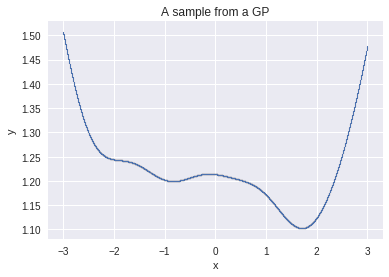

Picking different number of points from the function to run the NP alogorithm


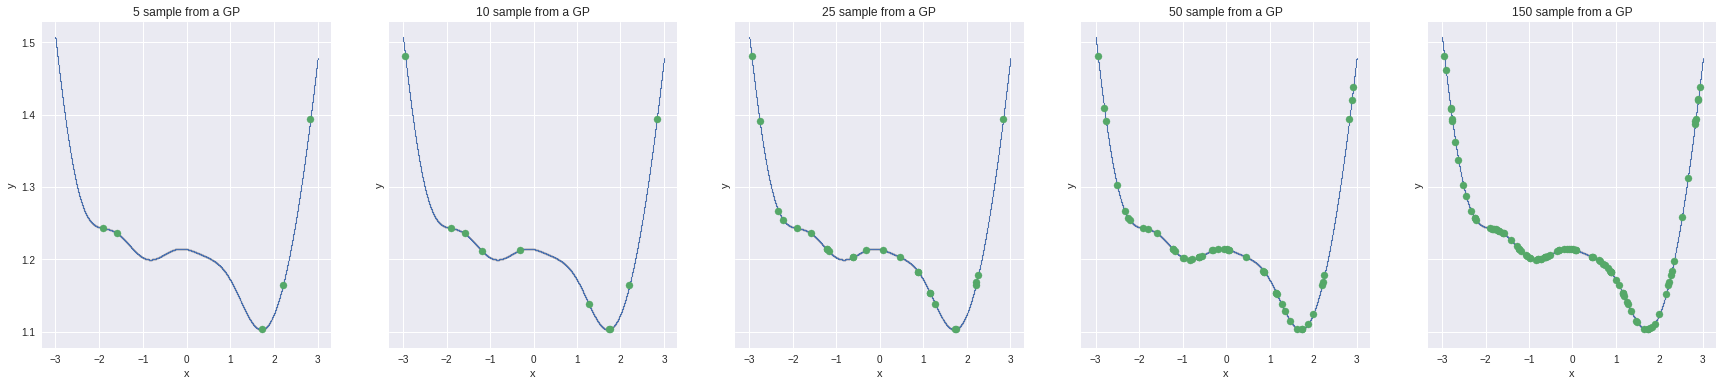

In [0]:
# Load the image
display(Image('../1sample_GP.png'))
print("Picking different number of points from the function to run the NP alogorithm")
display(Image('../context_points.png', width = 1200))


We will now run the NP algorithm to the above datasets. We will set both the dimension of $r$ and $z$ to be 1. From left to right, we see the progression of the algorithm against the number of iterations.  

For 5 data points


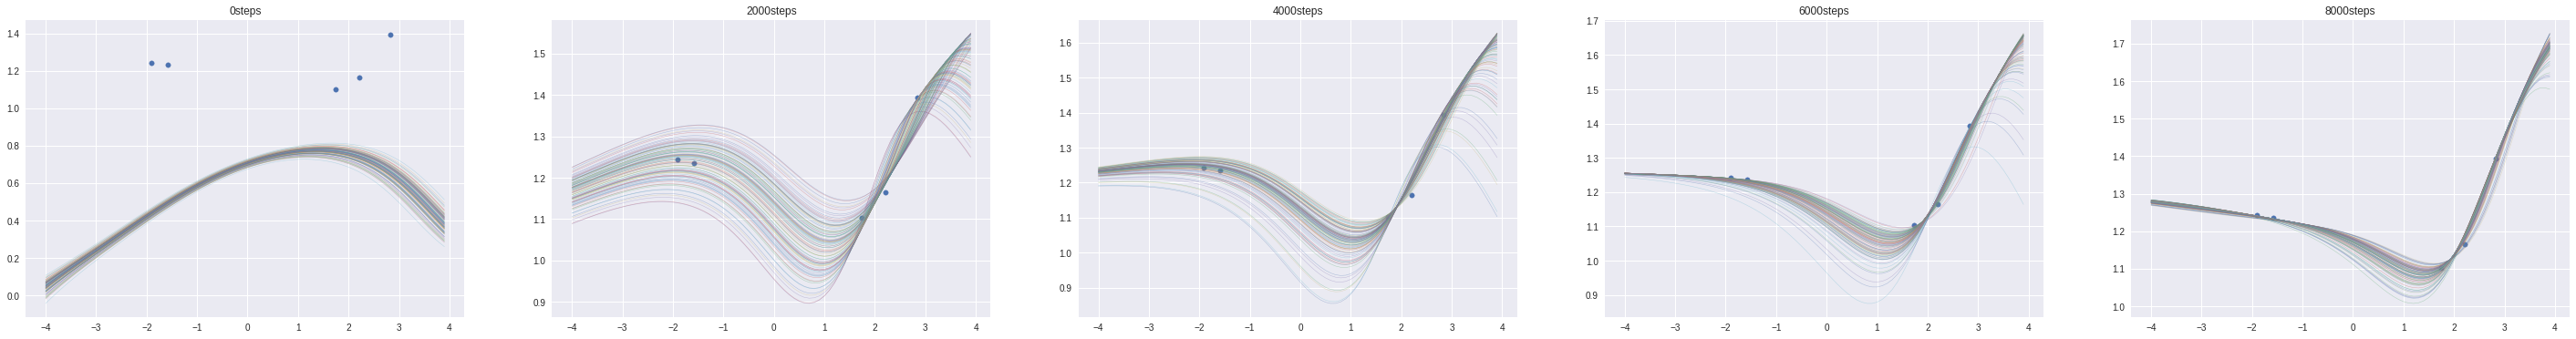

In [0]:
print("For 5 data points")
display(Image("../5 samples.png", width=1200, height=200))

### Conditional Neural Processes (CNPs)

Conditional Neural Processes (CNPs) are similar to NPs, but lack the global latent variable $z$, and thus cannot use the same context data to obtain different sampled functions. There is a deterministic connection between the context and target sets, so the resulting uncertainty cannot be modelled in the same way as with NPs. 

CNPs give a conditional distribution over functions $f \sim P$, given a set of observations. They are trained by taking a set $O$ of $n$ observations, and a random subset $O_N$ of N elements, $N \sim \text{Unif}(0, n-1)$. Then predictions of $O$ are made, based on $O_N$, and using gradient steps the conditional likelihood of the targets given $O_N$ is maximised. 

The architecture of CNPs is similar to that of NPs:

1. The observation set $O$ is first mapped through the R-encoder $h$, usually a neural network, to obtain the latent representations $\{r_i\}_{i=1}^n$. 

2. These latent representations are then aggregated in a permutation invariant manner, usually done by taking averages, to produce a single vector $r$.

3. $r$ and  $x^*$ are then passed to the decoder neural network $g$ to obtain predictions of $y^*$.

###Attentive Neural Processes (ANPs)

##Model-Agnostic Meta-Learning (MAML)

# Experiments

### Sine waves



```
# This is formatted as code
```

### Gaussian Processes

In [0]:
import numpy as np
import GPy
import matplotlib.pylab as plt

from NP_multitask_learning import *

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

%matplotlib inline
plt.style.use('seaborn')

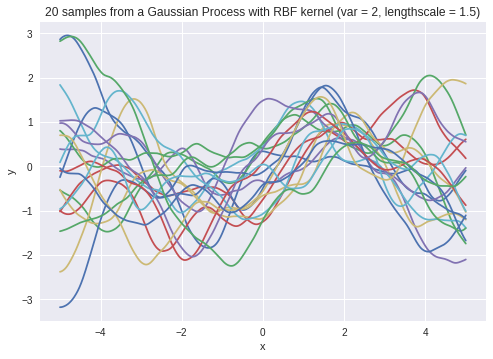

In [0]:
# Simulate a GP
x = np.random.uniform(-3, 3, (20, 1))
y = np.sin(x) + np.random.randn(20, 1) * 0.05

# Setup kernel
kernel = GPy.kern.Matern52(input_dim=1, variance=2, lengthscale=1.5)

# Setup model but not train it
m = GPy.models.GPRegression(x,y,kernel)

# Plot
xx = np.linspace(-5, 5, 1000).reshape(-1,1)
posterior_y = np.matrix(m.posterior_samples_f(X=xx, size=20))

for i in range(20):
    plt.plot(xx, posterior_y[:, i])
    plt.title("20 samples from a Gaussian Process with RBF kernel (var = 2, lengthscale = 1.5)")
    plt.xlabel("x")
    plt.ylabel("y")

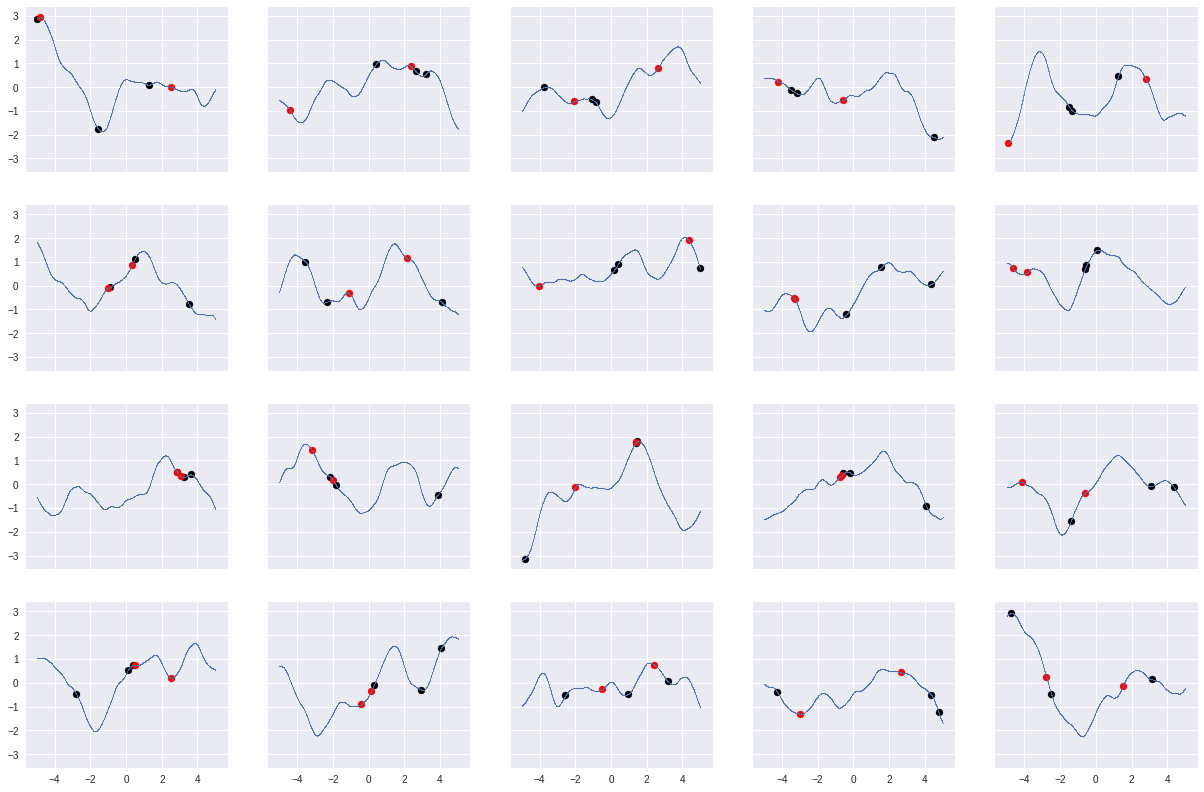

In [0]:
# Randomly pick 10 labels for each set
label_mat = np.matrix(np.random.choice(1000,size=(5,20)))
train_sets = []

for col in range(20):
    train_sets.append([xx.reshape(1,-1)[0][label_mat[:,col]], np.array(posterior_y[label_mat[:,col], col])])

    
x_train = dict()
y_train = dict()
x_test = dict()
y_test = dict()

for i in range(20):
    x_train["task " + str(i)] = train_sets[i][0][:3].astype(np.float32)
    y_train["task " + str(i)] = train_sets[i][1][:3].astype(np.float32)
    x_test["task " + str(i)] = train_sets[i][0][3:].astype(np.float32)
    y_test["task " + str(i)] = train_sets[i][1][3:].astype(np.float32)
    
    
    
fig, axes = plt.subplots(4, 5, figsize = (21, 14), sharex = True, sharey=True)

for i in range(20):
    axes[int(i/5), i%5].scatter(train_sets[i][0][:3], np.array(train_sets[i][1])[:3],c="black")
    axes[int(i/5), i%5].scatter(train_sets[i][0][3:], np.array(train_sets[i][1])[3:],c="r")
    axes[int(i/5), i%5].scatter(xx, np.array(posterior_y[:,i]), s=0.5)


In [0]:
# Train the NP to obtain the coders and the latent representation of the tasks
r_encoder, z_encoder, decoder, z_param_dict = NP_train_swap(x_train, y_train, [3,3,1,1], 30, 2)

In [0]:
import torch.

### Quadratic functions

The functions we consider in this section are of the form 
$$
f(x) = xQx^{T} + p
$$
and we take $x \in \mathbb{R}\;; Q, p \in \mathbb{R}, Q > 0$. 

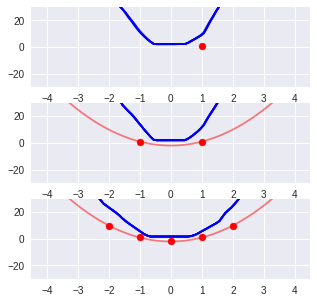

In [6]:
from collections.__init__ import namedtuple
from typing import Dict, Optional
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt

NeuralProcessParams = namedtuple('NeuralProcessParams', ['dim_r', 'dim_z', 'n_hidden_units_h', 'n_hidden_units_g'])
GaussianParams = namedtuple('GaussianParams', ['mu', 'sigma'])


def split_context_target(xs: np.array, ys: np.array, n_context: int,
                         context_xs: tf.Tensor, context_ys: tf.Tensor, target_xs: tf.Tensor, target_ys: tf.Tensor) \
        -> Dict[tf.Tensor, np.array]:
    """Split samples randomly into context and target sets
    """
    indices = set(range(ys.shape[0]))
    context_set_indices = set(random.sample(indices, n_context))
    target_set_indices = indices - context_set_indices

    return {
        context_xs: xs[list(context_set_indices), :],
        context_ys: ys[list(context_set_indices), :],
        target_xs: xs[list(target_set_indices), :],
        target_ys: ys[list(target_set_indices), :]
    }


def encoder_h(context_xys: tf.Tensor, params: NeuralProcessParams) -> tf.Tensor:
    """Map context inputs (x_i, y_i) to r_i

    Creates a fully connected network with a single sigmoid hidden layer and linear output layer.

    Parameters
    ----------
    context_xys
        Input tensor, shape: (n_samples, dim_x + dim_y)
    params
        Neural process parameters

    Returns
    -------
        Output tensor of encoder network
    """
    hidden_layer = context_xys
    # First layers are relu
    for i, n_hidden_units in enumerate(params.n_hidden_units_h):
        hidden_layer = tf.layers.dense(hidden_layer, n_hidden_units,
                                       activation=tf.nn.relu,
                                       name='encoder_layer_{}'.format(i),
                                       reuse=tf.AUTO_REUSE,
                                       kernel_initializer='normal')

    # Last layer is simple linear
    i = len(params.n_hidden_units_h)
    r = tf.layers.dense(hidden_layer, params.dim_r,
                        name='encoder_layer_{}'.format(i),
                        reuse=tf.AUTO_REUSE,
                        kernel_initializer='normal')
    return r


def aggregate_r(context_rs: tf.Tensor) -> tf.Tensor:
    """Aggregate the output of the encoder to a single representation

    Creates an aggregation (mean) operator to combine the encodings of multiple context inputs

    Parameters
    ----------
    context_rs
        Input encodings tensor, shape: (n_samples, dim_r)

    Returns
    -------
        Output tensor of aggregation result
    """
    mean = tf.reduce_mean(context_rs, axis=0)

    r = tf.reshape(mean, [1, -1])
    return r


def get_z_params(context_r: tf.Tensor, params: NeuralProcessParams) -> GaussianParams:
    """Map encoding to mean and covariance of the random variable Z

    Creates a linear dense layer to map encoding to mu_z, and another linear mapping + a softplus activation for Sigma_z

    Parameters
    ----------
    context_r
        Input encoding tensor, shape: (1, dim_r)
    params
        Neural process parameters

    Returns
    -------
        Output tensors of the mappings for mu_z and Sigma_z
    """
    mu = tf.layers.dense(context_r, params.dim_z, name="z_params_mu", reuse=tf.AUTO_REUSE, kernel_initializer='normal')

    sigma = tf.layers.dense(context_r, params.dim_z, name="z_params_sigma", reuse=tf.AUTO_REUSE,
                            kernel_initializer='normal')
    sigma = tf.nn.softplus(sigma)

    return GaussianParams(mu, sigma)


def decoder_g(z_samples: tf.Tensor, input_xs: tf.Tensor, params: NeuralProcessParams,
              noise_std: float = 0.05) -> GaussianParams:
    """Determine output y* by decoding input and latent variable

    Creates a fully connected network with a single sigmoid hidden layer and linear output layer.

    Parameters
    ----------
    z_samples
        Random samples from the latent variable distribution, shape: (n_z_draws, dim_z)
    input_xs
        Input values to predict for, shape: (n_x_samples, dim_x)
    params
        Neural process parameters
    noise_std
        Constant standard deviation used on output

    Returns
    -------
        Output tensors for the parameters of Gaussian distributions for target outputy, where its mean mu has shape
        (n_x_samples, n_z_draws)
        TODO: this assumes/forces dim_y = 1
    """
    # inputs dimensions
    # z_sample has dim [n_draws, dim_z]
    # x_star has dim [N_star, dim_x]

    n_draws = z_samples.get_shape().as_list()[0]
    n_xs = tf.shape(input_xs)[0]

    # Repeat z samples for each x*
    z_samples_repeat = tf.expand_dims(z_samples, axis=1)
    z_samples_repeat = tf.tile(z_samples_repeat, [1, n_xs, 1])

    # Repeat x* for each z sample
    x_star_repeat = tf.expand_dims(input_xs, axis=0)
    x_star_repeat = tf.tile(x_star_repeat, [n_draws, 1, 1])

    # Concatenate x* and z
    # shape: (n_z_draws, n_xs, dim_x + dim_z)
    inputs = tf.concat([x_star_repeat, z_samples_repeat], axis=2)

    hidden_layer = inputs
    # First layers are relu
    for i, n_hidden_units in enumerate(params.n_hidden_units_g):
        hidden_layer = tf.layers.dense(hidden_layer, n_hidden_units,
                                       activation=tf.nn.relu,
                                       name='decoder_layer_{}'.format(i),
                                       reuse=tf.AUTO_REUSE,
                                       kernel_initializer='normal')

    # Last layer is simple linear
    i = len(params.n_hidden_units_g)
    hidden_layer = tf.layers.dense(hidden_layer, 1,
                                   name='decoder_layer_{}'.format(i),
                                   reuse=tf.AUTO_REUSE,
                                   kernel_initializer='normal')

    # mu will be of the shape [N_star, n_draws]
    mu_star = tf.squeeze(hidden_layer, axis=2)
    mu_star = tf.transpose(mu_star)

    sigma_star = tf.constant(noise_std, dtype=tf.float32)

    return GaussianParams(mu_star, sigma_star)


def xy_to_z_params(context_xs: tf.Tensor, context_ys: tf.Tensor,
                   params: NeuralProcessParams, encoder_h) -> GaussianParams:
    """Wrapper to create full network from context samples to parameters of pdf of Z

    Parameters
    ----------
    context_xs
        Tensor with context features, shape: (n_samples, dim_x)
    context_ys
        Tensor with context targets, shape: (n_samples, dim_y)
    params
        Neural process parameters

     encoder_h
        Neural process generator function

    Returns
    -------
        Output tensors of the mappings for mu_z and Sigma_z
    """
    xys = tf.concat([context_xs, context_ys], axis=1)
    rs = encoder_h(xys, params)
    r = aggregate_r(rs)
    z_params = get_z_params(r, params)

    return z_params


def init_neural_process(context_xs: tf.Tensor, context_ys: tf.Tensor,
                        target_xs: tf.Tensor, target_ys: tf.Tensor,
                        params: NeuralProcessParams,encoder_h, decoder_g,
                        learning_rate=0.001, n_draws=7):
    """Set up complete, trainable neural process

    This will set up the full neaural process, including encoder, decoder, loss function and training operator. Any
    calls to network setup or prediction functions will reuse (parts of) the operations created here.

    Parameters
    ----------
    context_xs
        (Placeholder) tensor of the features in the context set, shape (n_samples, dim_x)
    context_ys
        (Placeholder) tensor of the outputs in the context set, shape (n_samples, dim_y)
    target_xs
        (Placeholder) tensor of the features in the target set, shape (n_target, dim_x)
    target_ys
        (Placeholder) tensor of the outputs in the target set, shape (n_targets, dim_y)
    params
        Neural process parameters
    learning_rate
        Base learning rate used in Adam optimizer
    n_draws
        Number of draws of Z per context set, or number of predictions made per target

    """
    # Concatenate context and target
    x_all = tf.concat([context_xs, target_xs], axis=0)
    y_all = tf.concat([context_ys, target_ys], axis=0)

    # Map input to z
    z_context = xy_to_z_params(context_xs, context_ys, params, encoder_h)
    z_all = xy_to_z_params(x_all, y_all, params, encoder_h)

    # Sample z
    epsilon = tf.random_normal([n_draws, params.dim_z])
    z_samples = tf.multiply(epsilon, z_all.sigma)
    z_samples = tf.add(z_samples, z_all.mu)

    # Map (z, x*) to y*
    y_pred_params = decoder_g(z_samples, target_xs, params)

    # ELBO
    loglike = loglikelihood(target_ys, y_pred_params)
    KL_loss = KLqp_gaussian(z_all.mu, z_all.sigma, z_context.mu, z_context.sigma)
    loss = tf.negative(loglike) + KL_loss

    # optimisation
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    return train_op, loss


def prior_predict(input_xs_value: np.array, params: NeuralProcessParams, decoder_g,
                  epsilon: Optional[tf.Tensor] = None, n_draws: int = 1) -> GaussianParams:
    """Predict output with random network

    This can be seen as a prior over functions, where no training and/or context data is seen yet. The decoder g is
    randomly initialised, and random samples of Z are drawn from a standard normal distribution, or taken from
    `epsilon` if provided.

    Parameters
    ----------
    input_xs_value
        Values of input features to predict for, shape: (n_samples, dim_x)
    params
        Neural process parameters
    epsilon
        Optional samples for Z. If omitted, samples will be drawn from a standard normal distribution.
        Shape: (n_draws, dim_z)
    n_draws
        Number of samples for Z to draw if `epsilon` is omitted

    Returns
    -------
        Output tensors for the parameters of Gaussian distributions for y*
    """
    x_star = tf.constant(input_xs_value, dtype=tf.float32)

    # the source of randomness can be optionally passed as an argument
    if epsilon is None:
        epsilon = tf.random_normal((n_draws, params.dim_z))
    z_sample = epsilon

    y_star = decoder_g(z_sample, x_star, params)
    return y_star


def posterior_predict(context_xs_value: np.array, context_ys_value: np.array, input_xs_value: np.array,
                      params: NeuralProcessParams, encoder_h, decoder_g,
                      epsilon: Optional[tf.Tensor] = None, n_draws: int = 1) -> GaussianParams:
    """Predict posterior function value conditioned on context

    Parameters
    ----------
    context_xs_value
        Array of context input values; shape: (n_samples, dim_x)
    context_ys_value
        Array of context output values; shape: (n_samples, dim_x)
    input_xs_value
        Array of input values to predict for, shape: (n_targets, dim_x)
    params
        Neural process parameters
    epsilon
        Source of randomness for drawing samples from latent variable
    n_draws
        How many samples to draw from latent variable; ignored if epsilon is given

    Returns
    -------
        Output tensors for the parameters of Gaussian distributions for y*
    """

    # Inputs for prediction time
    xs = tf.constant(context_xs_value, dtype=tf.float32)
    ys = tf.constant(context_ys_value, dtype=tf.float32)
    x_star = tf.constant(input_xs_value, dtype=tf.float32)

    # For out-of-sample new points
    z_params = xy_to_z_params(xs, ys, params, encoder_h)

    # the source of randomness can be optionally passed as an argument
    if epsilon is None:
        epsilon = tf.random_normal((n_draws, params.dim_z))
    z_samples = tf.multiply(epsilon, z_params.sigma)
    z_samples = tf.add(z_samples, z_params.mu)

    y_star = decoder_g(z_samples, x_star, params)

    return y_star
  
def KLqp_gaussian(mu_q: tf.Tensor, sigma_q: tf.Tensor, mu_p: tf.Tensor, sigma_p: tf.Tensor) -> tf.Tensor:
    """Kullback-Leibler divergence between two Gaussian distributions

    Determines KL(q || p) = < log( q / p ) >_q

    Parameters
    ----------
    mu_q
        Mean tensor of distribution q, shape: (1, dim)
    sigma_q
        Variance tensor of distribution q, shape: (1, dim)
    mu_p
        Mean tensor of distribution p, shape: (1, dim)
    sigma_p
        Variance tensor of distribution p, shape: (1, dim)

    Returns
    -------
        KL tensor, shape: (1)
    """
    sigma2_q = tf.square(sigma_q) + 1e-16
    sigma2_p = tf.square(sigma_p) + 1e-16
    temp = sigma2_q / sigma2_p + tf.square(mu_q - mu_p) / sigma2_p - 1.0 + tf.log(sigma2_p / sigma2_q + 1e-16)
    return 0.5 * tf.reduce_sum(temp)


def loglikelihood(y_star: tf.Tensor, y_pred_params: GaussianParams):
    """Log-likelihood of an output given a predicted """
    p_normal = tf.distributions.Normal(loc=y_pred_params.mu, scale=y_pred_params.sigma)
    loglike = p_normal.log_prob(y_star)
    loglike = tf.reduce_sum(loglike, axis=0)
    loglike = tf.reduce_mean(loglike)
    return loglike
 


# Set up NP parameters
params = NeuralProcessParams(dim_r=2, dim_z=2, n_hidden_units_h=[32, 32], n_hidden_units_g=[32, 32, 32])

tf.reset_default_graph()
sess = tf.Session()

# Placeholders for training inputs
x_context = tf.placeholder(tf.float32, (None, 1))
y_context = tf.placeholder(tf.float32, (None, 1))
x_target = tf.placeholder(tf.float32, (None, 1))
y_target = tf.placeholder(tf.float32, (None, 1))

# Set up NN
train_op, loss = init_neural_process(x_context, y_context, x_target, y_target,
                                     params, encoder_h, decoder_g, learning_rate=0.001)

# Initialise
init = tf.global_variables_initializer()
sess.run(init)

# Number of training iterations
n_iter = 100000
loss_freq = n_iter/10

train_xs = []
train_q = []
train_ys = []
train_p = []

# Training:
for i in range(n_iter):
    n_obs = 20 # Number of points in the observation set
    xs = np.random.uniform(-5, 5, n_obs) 
    q = random.uniform(0.001, 20)
    p = random.uniform(-10, 10)
    ys = q * (xs)**2 + p

    train_xs.append(xs)
    train_q.append(q)
    train_p.append(p)
    train_ys.append(ys)

    n_context = random.choice(range(1, 11)) # Context points from the observation set
    feed_dict = split_context_target(xs.reshape(-1, 1), ys.reshape(-1, 1), n_context, x_context, y_context, x_target,
                                     y_target)
    a = sess.run((train_op, loss), feed_dict=feed_dict)
    #if i % loss_freq == 0:
    #    print("Loss: {:.3f}".format(a[1]))

# Make a target set
q = 3
p = -2
xs = np.random.uniform(-5, 5, 5)
ys = q * (xs)**2 + p
x_star = np.linspace(-5, 5, 100)
y_star = q * (x_star)**2 + p

# Function to plot draws from the posterior, and the target
def plot_prediction(ax, xs, ys, x_star, y_star, plot_true = True, xlim = (-4.5, 4.5), ylim=(-1.5, 1.5), sess= tf.get_default_session()):
    posterior_predict_op = posterior_predict(
        xs.reshape((-1,1)),
        ys.reshape((-1,1)),
        x_star.reshape((-1,1)),
        params, encoder_h, decoder_g, n_draws=50)
    y_star_mat = sess.run(posterior_predict_op.mu)

    for i in range(y_star_mat.shape[1]):
        ax.plot(x_star, y_star_mat.T[i], c='b', alpha=0.1)
    if plot_true:
        ax.plot(x_star, y_star, c='r', alpha=.5)
    ax.scatter(xs, ys, c='r')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig, axes = plt.subplots(3, 1, figsize=(5,5))
xss = [np.array(xs) for xs in [[1], [-1, 1], [-2, -1, 0, 1, 2]]]
yss = [q * (xs)**2 + p for xs in xss]
plot_true = False
ylim=(-30, 30)
for ax, xs, ys in zip(axes, xss, yss):
    plot_prediction(ax, xs, ys, x_star, y_star, plot_true = plot_true, ylim = ylim, sess=sess)
    plot_true = True
    ylim=(-30, 30)

plt.show()

### Polynomials

### Discussion

# Discussion